In [245]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import utils

tests_elapsed_path = "tests_elapsed_times.json"
costs_path = "machine_costs.csv"  

## 1. Loading the data

In [246]:
costs_df = pd.read_csv(costs_path)
with open(tests_elapsed_path) as f:
    elapsed_times = json.load(f)

### 1.1 Creating a dataframe with the elapse_times data

- Columns: model, task, machine, num_fewshot, batch_size, elapsed_time

In [247]:
columns = ["model", "task", "machine", "num_fewshot", "batch_size", "elapsed_time"]
costs_calc = utils.CostsCalculator(elapsed_times, columns)
elapsed_times_df = costs_calc.get_elapsed_times_df()

### 1.2 Adding a costs column for every machine in the costs_df

In [248]:
df = costs_calc.add_costs_column(costs_df, runs_df = elapsed_times_df)

## 2. Averaging the elapsed_times for every (model, task, machine, num_fewshot, batch_size) combination

### 2.1 Grouping the hendrycksTests tasks into one MMLU task

In [249]:
run_configs = ["model", "task", "machine", "num_fewshot", "batch_size"]
pattern = 'hendrycksTest'
mmlu_tasks_df = df[df["task"].str.contains(pattern)]
mmlu_total = len(mmlu_tasks_df)
grouped_data = mmlu_tasks_df.groupby(run_configs).agg({"elapsed_time": "sum", "cost(US$)": "sum"})
grouped_df = pd.DataFrame(grouped_data).reset_index()
grouped_df["task"] = "mmlu_"+str(mmlu_total)+"/57"
df = df[~df['task'].str.contains(pattern)]
df = pd.concat([df, grouped_df], axis=0)

In [250]:
run_configs = ["model", "task", "machine", "num_fewshot", "batch_size"]
grouped_df = df.groupby(run_configs).agg(
    average_elapsed_time=('elapsed_time', 'mean'),
    average_cost=('cost(US$)', 'mean'),
    std_elapsed_time=('elapsed_time', 'std'),
    std_cost=('cost(US$)', 'std')
).reset_index()
print(grouped_df.columns)

Index(['model', 'task', 'machine', 'num_fewshot', 'batch_size',
       'average_elapsed_time', 'average_cost', 'std_elapsed_time', 'std_cost'],
      dtype='object')


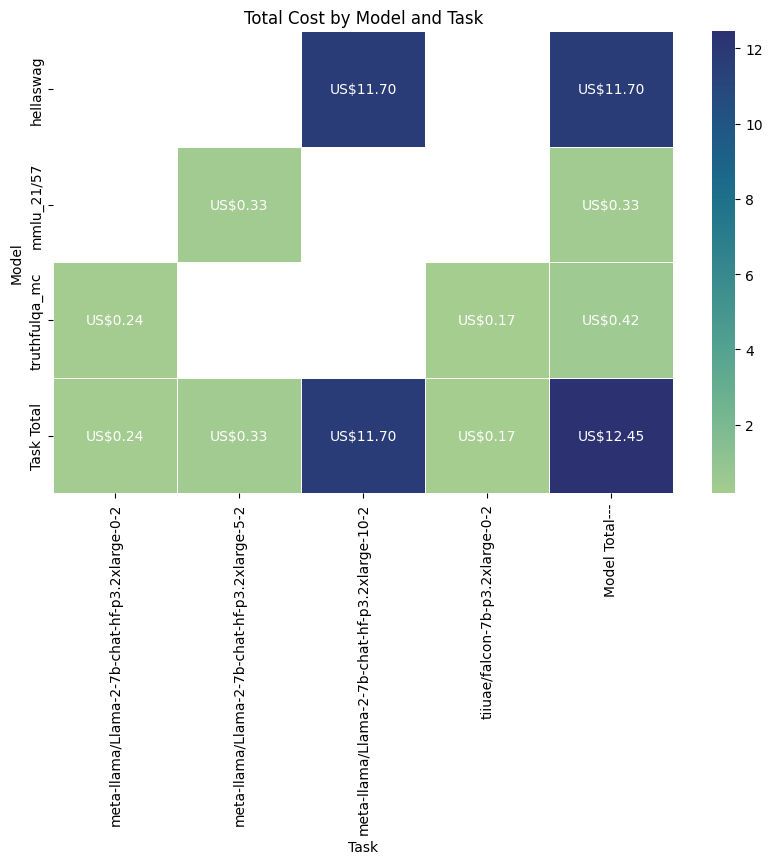

In [251]:
pivot_df = grouped_df.pivot_table(index="task", 
                       columns=["model", "machine", "num_fewshot", "batch_size"], values='average_cost', aggfunc='sum')

row_totals = pivot_df.sum(axis=1)
column_totals = pivot_df.sum(axis=0)
pivot_df['Model Total'] = row_totals
pivot_df.loc['Task Total'] = column_totals
pivot_df.loc['Task Total', 'Model Total'] = pivot_df.iloc[:-1, :-1].sum().sum()

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.heatmap(pivot_df, cmap='crest', annot=False, fmt=".2f", linewidths=0.5,  annot_kws={"size": 20})

# Add labels and title
plt.xlabel('Task')
plt.ylabel('Model')
plt.title('Total Cost by Model and Task')

for i in range(len(pivot_df)):
    for j in range(len(pivot_df.columns)):
        text = "US${:.2f}".format(pivot_df.iloc[i, j])
        plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='white', fontsize=10)

# Show the heatmap
plt.show()